<div style="color:#8b1538; font-size:35px;">Benchmark of stairway plot 2</div>

In [1]:
import ast
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sei.files.files as f
import sei.graphics.plot as plot
import sei.simulation.msprime as ms
import sei.sei as sei

<br>

# Stairway plot 2 inference

<div style="color: #8b1538; font-size: 32px">1. Log-likelihood ratio test</div><br>

Likelihood ratio test lrt assess the godness fit of two model. It's allow you to test wheter adding parameters to models significantly increase the likelihood the model.

1. Likelihood ratio test

\begin{equation}
\large{ lrt = -2*\frac{L0}{L1} }
\end{equation}

with L0 the likelihood of m0 and L1 the likelihood of m1 <br>

2. Log-likelihood ratio test

\begin{equation}
\large{ log(lrt) = 2 * (log_{10}L1 - log_{10}L0) }
\end{equation}

with $log_{10}L0$ the log-likelihood of m0 and $log_{10}L1$ the log-likelihood of m1

<br>

**Models**

* M0 a n0-parameter model - the model with less parameters

* M1 a n1-parameter model - the model with more parameters

with n0 < n1 (number of parameters)

<br>

**Hypothesis**

* H0 the null hypothesis - adding the parameter(s) does not significantly increase the likelihood of the model

* H1 the alternative hypothesis - adding the parameter(s) significantly increase the likelihood of the model

<br>

**Decision rule**

* If p-value >= $\alpha$ then the test is insignificant and do not reject of H0

* If p-value < $\alpha$ then the test is significant and reject of H0

with $\alpha = 0.05$

<br>

**Degrees of freedom**

The difference in the number of parameters between M0 and M1, i.e. n1 - n0

> Load Data for stairway inference

In [2]:
data_decline = f.export_stairway_files(model="decline", fold=False)

In [3]:
save = True

> Log-likelihood ratio test between M0 & M1

In [4]:
ll_m1_decline = sei.stairway_ll_test(data_decline, 'm1')

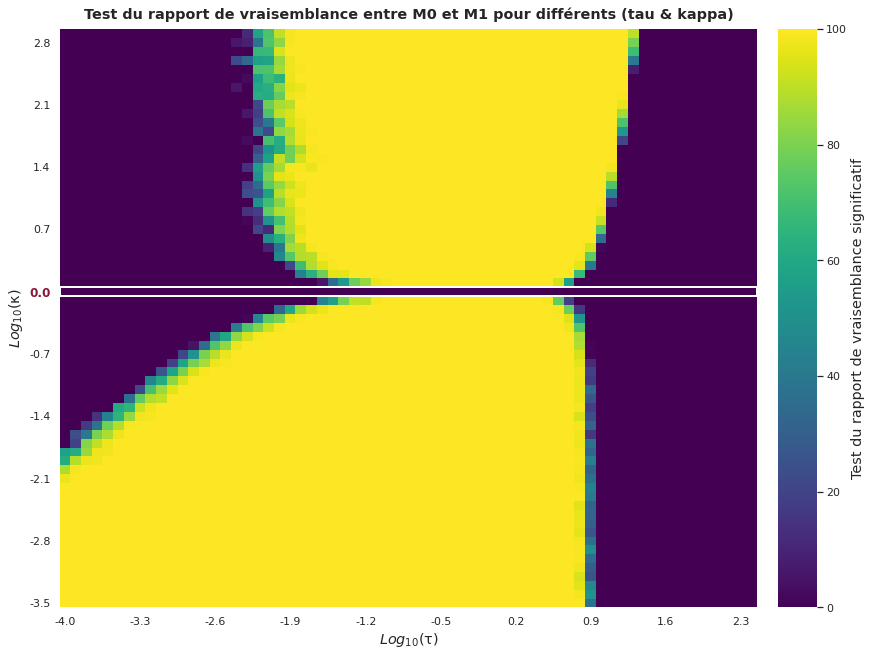

In [6]:
if save:
    title = "Test du rapport de vraisemblance entre M0 et M1 pour différents (tau & kappa)"
    cbar = "Test du rapport de vraisemblance significatif"
else:
    title = "Log likelihood ratio test for various tau & kappa (M0 & M1)"
    cbar = "Significant log-likelihood ratio test"

plot.plot_stairway_heatmap(data=ll_m1_decline, title=title, cbar=cbar, save=save)

> Log-likelihood ratio test between M1 & final model

In [7]:
ll_final_decline = sei.stairway_ll_test(data_decline, 'final')

In [8]:
df = ll_m1_decline.pivot('Kappa', 'Tau', 'Positive hit')

# Mask
mask = []
for _, row in df.iterrows():
    tmp = []
    for hit in row:
        tmp += [True] if hit == 0. else [False]
    mask.append(tmp)
mask = np.array(mask)
    

def plot_stairway_heatmap(data, title, cbar, mask):
    """
    Heatmap for stairway data

    Parameter
    ---------
    data: pandas DataFrame
        DataFrame of 4225 rows and 3 columns
          - 1st column: Either Tau or m12
          - 2nd column: Kappa
          - 3rd column: Either Positive hit or Ne
    """
    # Set up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')

    # Pre-processing data
    df = data.pivot(index=data.columns[1], columns=data.columns[0], values=data.columns[2])
    
    # Plot
    ax = sns.heatmap(df, mask=mask, cmap='coolwarm')
    ax.set_facecolor("#000066")
    
    # Heatmap x and y-axis personnalization
    plot.heatmap_axis(ax=ax, xaxis=df.columns.name, yaxis=df.index.name, cbar=cbar)

    # Title
    #title = "Distance between min & max Ne"
    plt.title(title, fontsize="x-large", color="#8b1538")

    plt.plot()

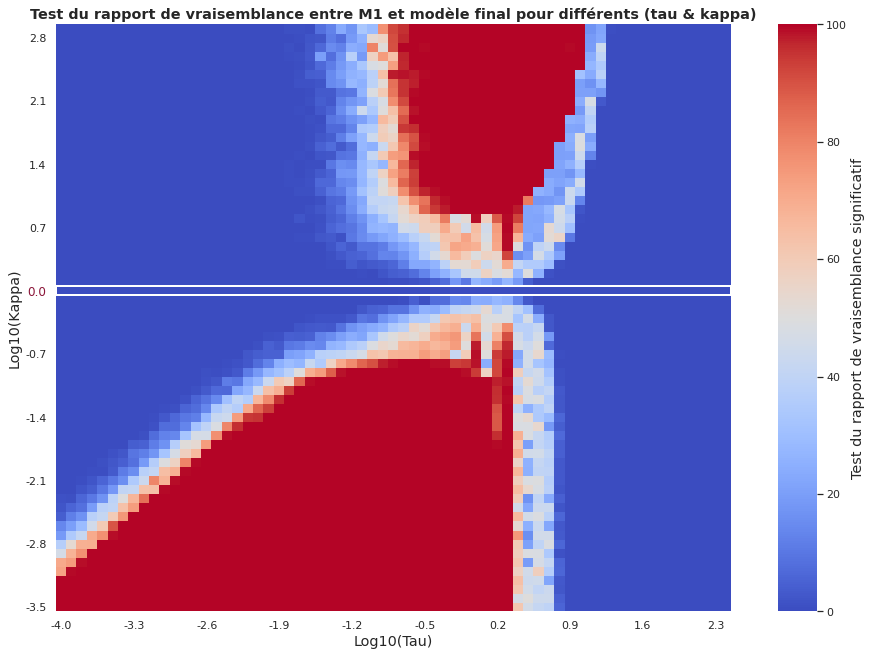

In [35]:
if save:
    title = "Test du rapport de vraisemblance entre M1 et modèle final pour différents (tau & kappa)"
    cbar = "Test du rapport de vraisemblance significatif"
else:
    title = "Log likelihood ratio test for various tau & kappa (M1 & final)"
    cbar = "Significant log-likelihood ratio test"

plot_stairway_heatmap(data=ll_final_decline, title=title, cbar=cbar, save=save)

> Différence de dimension

In [9]:
def stairway_dimension_comparaison(data):
    key = [param for param in data.iloc[0]['Parameters'].keys()]
    df = pd.DataFrame(columns=[key[0], key[1], 'Dimensions'])

    # Pre-processing data
    for _, row in data.iterrows():
        # Extract parameters use to generate the observed SFS
        # Then compute log10 of these parameters
        dico = {}
        for param in row['Parameters'].keys():
            dico[param] = round(np.log10(row['Parameters'][param]), 2)
        
        # Compute log-likelihood ratio test
        # For some inference there are only 1 dimension, in this case the LL of M1 is None
        dim_final = [len(ele) for ele in row['Final']['Theta']]
        dim_m1 = 2
        
        dimensions = [
            0 if ll_m1 is None else dim - dim_m1 for ll_m1, dim in zip(row['M1']['LL'], dim_final)
        ]
        
        dico['Dimensions'] = np.mean(dimensions)
        
        # Add to pandas DataFrame df
        df = df.append(dico, ignore_index=True)
        
    return df

In [10]:
dimension_decline = stairway_dimension_comparaison(data_decline)

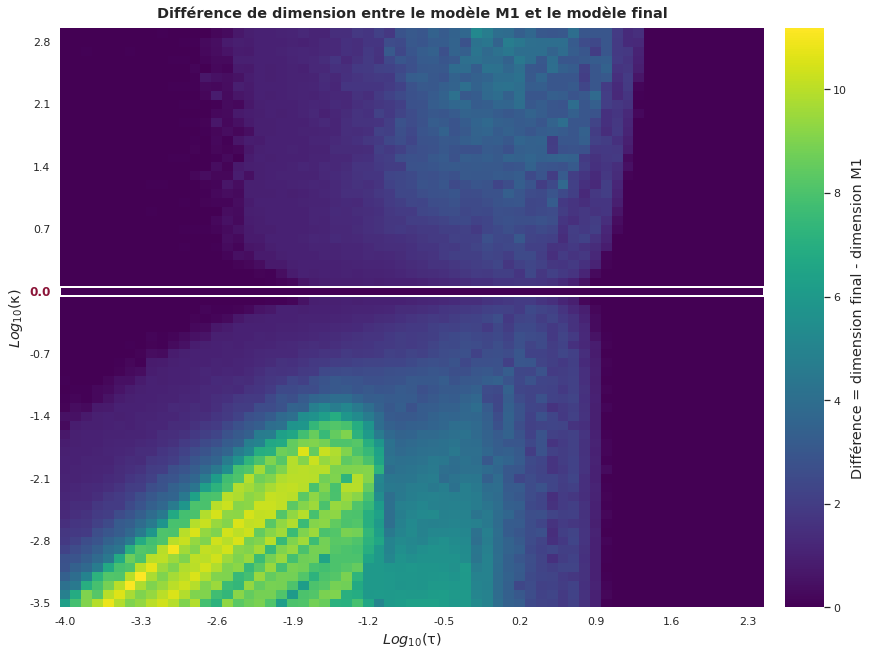

In [11]:
if save:
    title = "Différence de dimension entre le modèle M1 et le modèle final"
    cbar = "Différence = dimension final - dimension M1"
else:
    title = "Difference between m1's dimension and final model's dimension for various tau & kappa"
    cbar = "Difference = final dimension - M1 dimension"

plot.plot_stairway_heatmap(data=dimension_decline, title=title, cbar=cbar, save=save)

> Detection changement de taille de population

Changement de taille significatif

In [4]:
ne_decline = sei.stairway_distance_ne(data_decline)

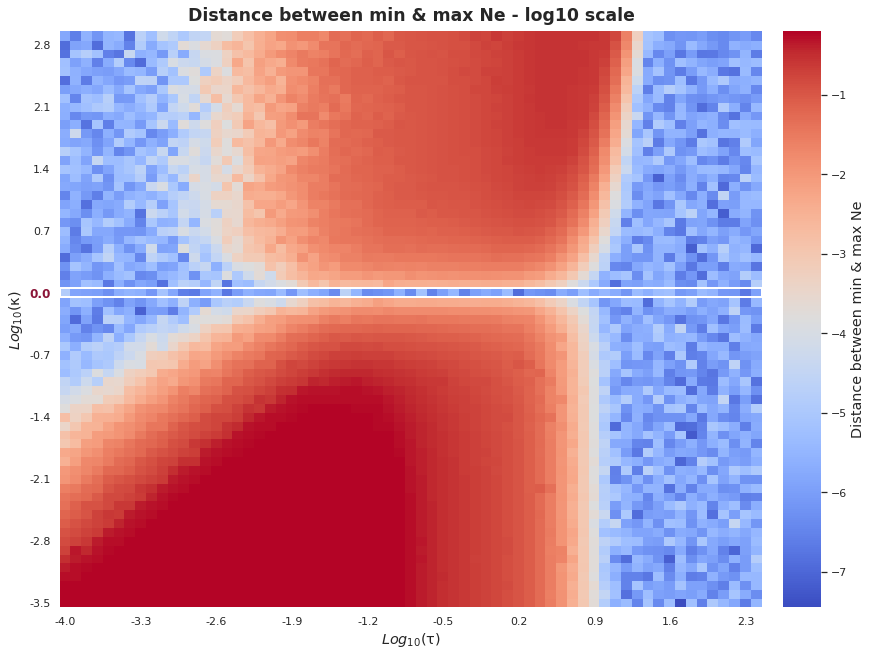

In [5]:
title = "Distance between min & max Ne - log10 scale"
cbar = "Distance between min & max Ne"

plot.plot_stairway_heatmap(data=ne_decline, title=title, cbar=cbar, save=save)

> Estimation parameters

In [49]:
def stairway_distance_param(data, parameter):
    key = [param for param in data.iloc[0]['Parameters'].keys()]
    df = pd.DataFrame(columns=[key[0], key[1], 'Distance'])
    
    # Pre-processing data
    for _, row in data.iterrows():
        # Extract parameters use to generate the observed SFS
        # Then compute log10 of these parameters
        dico = {}
        for param in row['Parameters'].keys():
            dico[param] = round(np.log10(row['Parameters'][param]), 2)
        
        # Compute estimated
        if parameter == 'kappa':
            if dico["Kappa"] > 0:  # Décroissance
                estimated = row['Ne ancestral'] / row['Ne initial']
            else:  # Croissance
                estimated = row['Ne initial'] / row['Ne ancestral']
            
        elif parameter == 'tau':
            estimated = abs(row['Year'][0] - row['Year'][1]) / 2

        # Compute distance - (estimated - observed)**2 / estimated
        dico['Distance'] = np.log10(np.power(estimated - row['Parameters'][param], 2) / row['Parameters'][param])
        
        # Add to pandas DataFrame df
        df = df.append(dico, ignore_index=True)
        
    return df

In [50]:
kappa_decline = stairway_distance_param(data_decline, parameter='kappa')

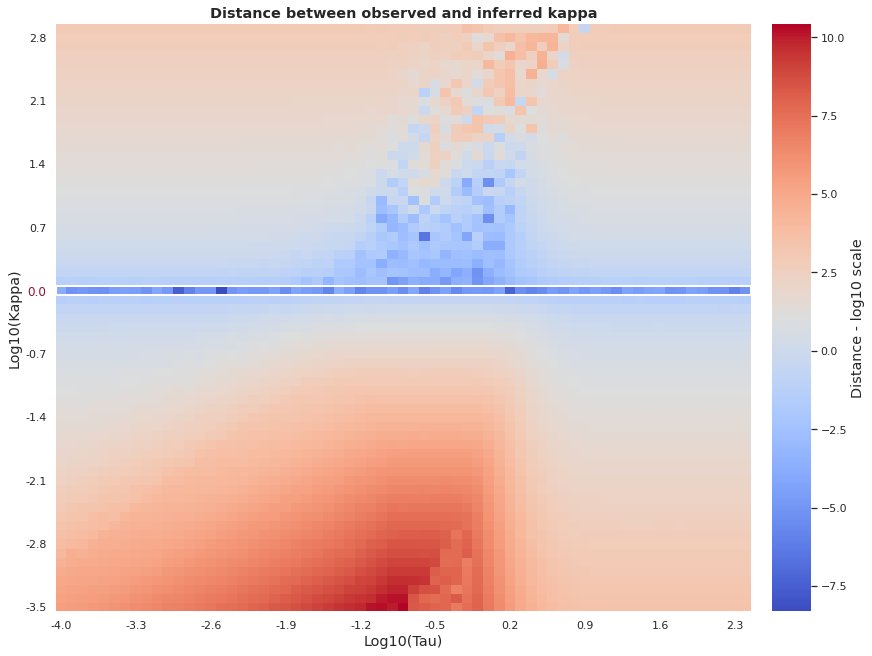

In [41]:
title = "Distance between observed and inferred kappa"
cbar = "Distance - log10 scale"

plot_stairway_heatmap(data=kappa_decline, title=title, cbar=cbar, save=False)

In [51]:
tau_decline = stairway_distance_param(data_decline, parameter='tau')

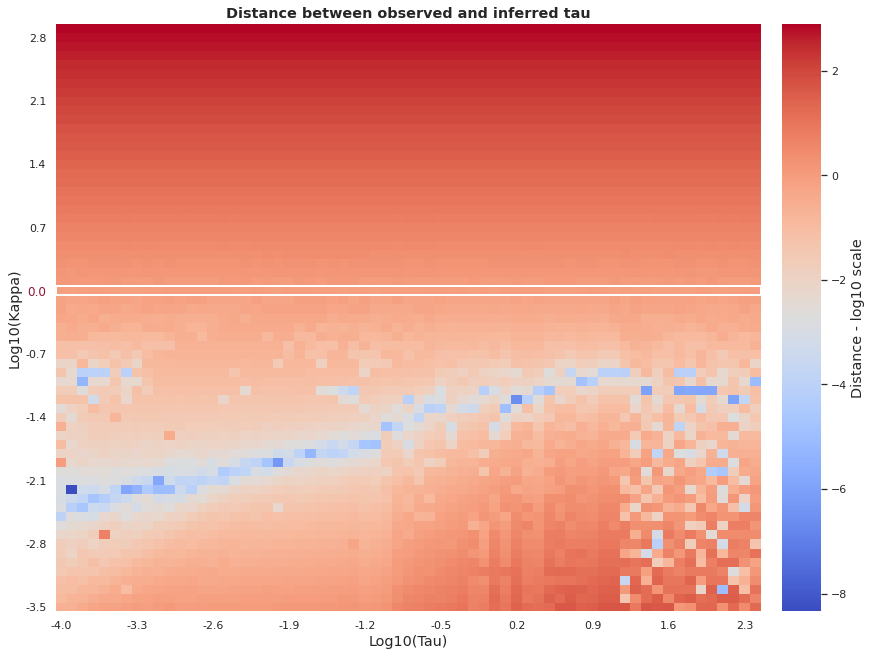

In [52]:
title = "Distance between observed and inferred tau"
cbar = "Distance - log10 scale"

plot_stairway_heatmap(data=tau_decline, title=title, cbar=cbar, save=False)

<br>

### Constan population

Stairway plot inference for some constant population with Ne = 1, Ne = 2, Ne = 10 & Ne = 100.

In [2]:
def sfs_cst_pop():
    # DataFrame
    data = pd.DataFrame(columns=['Parameters', 'SNPs', 'SFS observed'])
    
    # Parameters for the simulation
    params = {"sample_size": 20, "Ne": 0, "rcb_rate": 2e-2, "mu": 2e-2, "length": 1e5}
    
    for ne in [1, 2, 10]:
        params['Ne'] = ne
        
        # Constant scenario
        sfs = ms.msprime_simulation(model=ms.constant_model, params=params, debug=True)
        
        dico = {'Parameters': params.copy(), 'SNPs': [np.mean(sfs)], 'SFS observed': [sfs]}
        data = data.append(dico, ignore_index=True)
        
    return data


def inference_cst_pop(generate=False):
    if generate:
        data = sfs_cst_pop()
        data.to_json("./Data/Msprime/cst/SFS-cst")
    else:
        data = pd.read_json("./Data/Msprime/cst/SFS-cst")
        
    return data

In [3]:
simulation = inference_cst_pop(generate=False)

In [4]:
simulation

,Parameters,SNPs,SFS observed
0,"{'sample_size': 20, 'Ne': 1, 'rcb_rate': 0.02,...",[1462.1578947368],"[[7471, 4056, 2625, 1957, 1514, 1294, 1165, 10..."
1,"{'sample_size': 20, 'Ne': 2, 'rcb_rate': 0.02,...",[2986.1052631579],"[[15996, 8189, 5265, 4084, 3094, 2723, 2093, 2..."
2,"{'sample_size': 20, 'Ne': 10, 'rcb_rate': 0.02...",[15017.8421052632],"[[80377, 40178, 26825, 20229, 16309, 13161, 11..."


In [5]:
%%capture

for _, row in simulation.iterrows():
    sei.save_stairway_inference(row, 'cst')
    break

<br>

In [6]:
data = pd.read_json("./Data/Msprime/decline/SFS_decline-all")

Text(0.5, 1.0, "{'Tau': 0.0006309573, 'Kappa': 794.3282347243}")

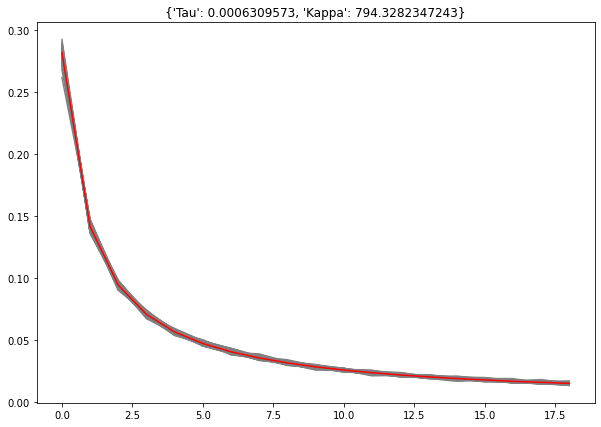

In [75]:
sfs = data.iloc[0]['SFS observed']
new = np.array([sum(spectrum) for spectrum in zip(*sfs)]) / len(sfs)

plt.figure(figsize=(10, 7))

for spectrum in sfs:
    plt.plot([ele/sum(spectrum) for ele in spectrum], color="grey")
plt.plot([ele/sum(new) for ele in new], color="red")
plt.title({k: v for k, v in data.iloc[0]['Parameters'].items() if k in ['Tau', 'Kappa']})